In [2]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [3]:
import deepinv as dinv
from pathlib import Path
from datetime import datetime
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity
from deepinv.models.complex import to_complex_denoiser

In [4]:
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
SAVE_DIR = DATA_DIR / dt_string
FIGURE_DIR = DATA_DIR / "first_results"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "random").mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "pseudorandom").mkdir(parents=True, exist_ok=True)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 14925 MB free memory 


device(type='cuda', index=0)

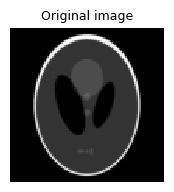

In [4]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)

plot(x, titles="Original image")

In [5]:
x.shape

torch.Size([1, 1, 99, 99])

In [6]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [5]:
def run_spec(
        y,
        physics,
        num_iter = 300,
):
    x_spec = physics.A_dagger(y, n_iter=num_iter)

    return x_spec

def run_gd(
        y,
        physics,
        oversampling,
        device,
        dtype = torch.cfloat,
        num_iter = 1500,
        stepsize = 0.005,
        data_fidelity = L2(),
        init = "random",
        spec_iter = 300,
):
    stepsize = stepsize * oversampling

    if init == "random":
        x_gd = torch.randn((y.shape[0],) + physics.img_shape).to(device)
    elif init == "spectral":
        x_gd = run_spec(y, physics, spec_iter)
    else:
        raise ValueError("init should be either 'random' or 'spectral'")

    for _ in range(num_iter):
        x_gd = x_gd - stepsize * data_fidelity.grad(x_gd, y, physics)
    
    return x_gd

def run_random_case(
        x,
        img_shape,
        device,
        dtype=torch.cfloat,
        noise_level=0.0,
        start=0.1,
        end=20.0,
        step=0.1,
        repeat=10,
):
    x = x.to(device)
    
    oversampling_series = list(np.arange(start,end+step,step))
    count = len(oversampling_series)
    
    res_gd_rand = torch.empty((count, repeat))
    res_spec = torch.empty((count, repeat))
    res_gd_spec = torch.empty((count, repeat))

    for i in tqdm(range(count)):
        oversampling = oversampling_series[i]
        m = int(oversampling * torch.prod(torch.tensor(img_shape)))
        for j in range(repeat):
            physics = dinv.physics.RandomPhaseRetrieval(
                m=m,
                img_shape=img_shape,
                noise_model=dinv.physics.GaussianNoise(sigma=noise_level),
                device=device,
            )
            y = physics(x)
            
            x_gd_rand = run_gd(y, physics, oversampling, init="random")
            x_spec = run_spec(y, physics)
            x_gd_spec = run_gd(y, physics, oversampling, init="spectral")

            # compute the cosine similarity
            res_gd_rand[i,j] = cosine_similarity(x_gd_rand, x)
            res_spec[i,j] = cosine_similarity(x_spec, x)
            res_gd_spec[i,j] = cosine_similarity(x_gd_spec, x)
    
    return res_gd_rand, res_spec, res_gd_spec

def generate_oversampling_series(img_shape, start=1, end=201):
    oversampling_series = []
    for i in range(start, end, 2):
        output_shape = (img_shape[0],) + (i, i)
        oversampling = torch.prod(torch.tensor(output_shape))/torch.prod(torch.tensor(img_shape))
        oversampling_series.append(oversampling)
    return oversampling_series

def run_pseudorandom_case(
        x,
        img_shape,
        device,
        dtype=torch.cfloat,
        noise_level=0.0,
        start=1,
        end=201,
        repeat=10,
        num_iter = 4000,
        stepsize = 0.005,
        spec_iter = 2500
):
    x = x.to(device)
    
    count = (end - start) // 2
    
    res_gd_rand = torch.empty((count, repeat))
    res_spec = torch.empty((count, repeat))
    res_gd_spec = torch.empty((count, repeat))

    for i in tqdm(range(start, end, 2)):
        output_shape = (img_shape[0],) + (i, i)
        oversampling = torch.prod(torch.tensor(output_shape))/torch.prod(torch.tensor(img_shape))
        for j in range(repeat):
            physics = dinv.physics.PseudoRandomPhaseRetrieval(
                n_layers=2,
                input_shape=img_shape,
                output_shape=output_shape,
                noise_model=dinv.physics.GaussianNoise(sigma=noise_level),
                device=device,
            )
            y = physics(x)
            
            x_gd_rand = run_gd(y, physics, oversampling, device=device, init="random", num_iter=num_iter, stepsize=stepsize)
            x_spec = run_spec(y, physics)
            x_gd_spec = run_gd(y, physics, oversampling, device=device, init="spectral", num_iter=num_iter, stepsize=stepsize, spec_iter=spec_iter)

            # compute the cosine similarity
            res_gd_rand[(i-start)//2,j] = cosine_similarity(x_gd_rand, x)
            res_spec[(i-start)//2,j] = cosine_similarity(x_spec, x)
            res_gd_spec[(i-start)//2,j] = cosine_similarity(x_gd_spec, x)
    
    return res_gd_rand, res_spec, res_gd_spec

def save_results(res_gd_rand, res_spec, res_gd_spec, dir):
    torch.save(res_gd_rand, dir / "res_gd_rand.pt")
    torch.save(res_spec, dir / "res_spec.pt")
    torch.save(res_gd_spec, dir / "res_gd_spec.pt")

def load_results(dir):
    res_gd_rand = torch.load(dir / "res_gd_rand.pt")
    res_spec = torch.load(dir / "res_spec.pt")
    res_gd_spec = torch.load(dir / "res_gd_spec.pt")
    
    return res_gd_rand, res_spec, res_gd_spec

def plot_results(oversampling_series, res_gd_rand, res_spec, res_gd_spec):
    plt.figure(figsize=(10,5))
    plt.plot(oversampling_series,torch.mean(res_gd_rand, axis=1), label="GD Random")
    plt.plot(oversampling_series,torch.mean(res_spec, axis=1), label="Spec")
    plt.plot(oversampling_series,torch.mean(res_gd_spec, axis=1), label="GD Spec")
    plt.xlabel("Oversampling")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.show()

In [18]:
# run pseudorandom case
res_gd_rand, res_spec, res_gd_spec = run_pseudorandom_case(
    x=x_phase,
    img_shape=x.shape[1:],
    device=device,
    noise_level=0.05,
    start=99,
    end=199,
    repeat=10,
    num_iter=1000,
    stepsize=0.005,
    spec_iter=2500
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [21:09<00:00, 25.40s/it]


In [19]:
SAVE_DIR

PosixPath('data/20240529-153219')

In [20]:
save_results(res_gd_rand, res_spec, res_gd_spec, SAVE_DIR/"pseudorandom")

In [21]:
res_spec

tensor([[0.0025, 0.0010, 0.0013, 0.0016, 0.0020, 0.0015, 0.0026, 0.0032, 0.0015,
         0.0019],
        [0.0027, 0.0013, 0.0029, 0.0018, 0.0004, 0.0011, 0.0026, 0.0011, 0.0014,
         0.0016],
        [0.0029, 0.0006, 0.0024, 0.0021, 0.0008, 0.0014, 0.0004, 0.0022, 0.0023,
         0.0017],
        [0.0026, 0.0018, 0.0035, 0.0017, 0.0025, 0.0031, 0.0024, 0.0026, 0.0011,
         0.0020],
        [0.0030, 0.0018, 0.0008, 0.0036, 0.0008, 0.0014, 0.0031, 0.0018, 0.0020,
         0.0019],
        [0.0025, 0.0007, 0.0013, 0.0031, 0.0017, 0.0029, 0.0021, 0.0005, 0.0015,
         0.0024],
        [0.0028, 0.0014, 0.0013, 0.0017, 0.0024, 0.0015, 0.0037, 0.0020, 0.0032,
         0.0024],
        [0.0029, 0.0036, 0.0017, 0.0030, 0.0017, 0.0036, 0.0018, 0.0005, 0.0015,
         0.0021],
        [0.0026, 0.0018, 0.0031, 0.0039, 0.0016, 0.0014, 0.0021, 0.0014, 0.0009,
         0.0016],
        [0.0016, 0.0011, 0.0026, 0.0030, 0.0025, 0.0026, 0.0009, 0.0025, 0.0023,
         0.0017],
        [0

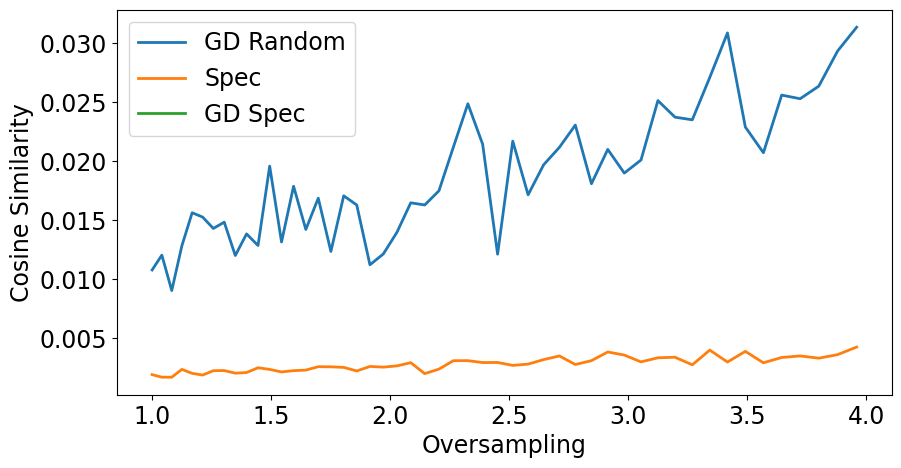

In [22]:
series = generate_oversampling_series(x.shape[1:],99,199)

plot_results(series, res_gd_rand, res_spec, res_gd_spec)

(100, 10)


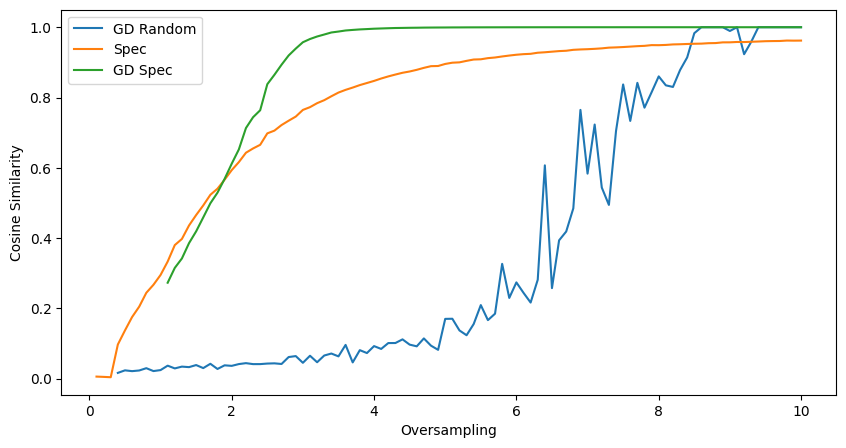

In [5]:
res_gd_rand = np.load("res_gd_rand.npy")
res_spec = np.load("res_spec.npy")
res_gd_spec = np.load("res_gd_spec.npy")
print(res_spec.shape)
plt.figure(figsize=(10,5))
plt.plot(np.arange(0.1,10.1,0.1),np.mean(res_gd_rand, axis=1), label="GD Random")
plt.plot(np.arange(0.1,10.1,0.1),np.mean(res_spec, axis=1), label="Spec")
plt.plot(np.arange(0.1,10.1,0.1),np.mean(res_gd_spec, axis=1), label="GD Spec")
plt.xlabel("Oversampling")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.show()